# Introduction

## Motivation 

The motivation for this document is to shade some light on the question of the best hashmap to be used in a particular application. Coming from a strong financial market data experience, I have watched several arguments for using the standard STL, several generic Github repos and commercial implementations. Arguments pro and con within usually a very heated argumentation that nonetheless lack measurable data! 

As an experienced engineer, I know better that compilers, computer micro-architectures and memory technologies change almost completely every five years, not always for the better. DDR Memory for example has almost tripled latency in the past ten years, which comes to a shock to many.

In our practice, clients (often traders and quants) complain looking at the final observable symptom: we are losing trades, we are being picked off by the market, we cannot hit that quote, my backtest is too slow. It is our expertise to drill down and find out what is happening, which is one of the services that keeps us growing every month. In those cases it is often possible to replace components and obtain a quick win that restores profitability, but the reach is obviously limited due to the complexity of dealing with (often undocumented) legacy code.

From time to time, we have been blessed with the opportunity to build a system from the ground up, which was the case with ULLTRA at JP Morgan that fuels most of the markets low latency trading (commodities, FX, rates, credit). In these cases, it is imperative to start with componentes tailored for the task, paying particular attention to data containers and related operations. 

In this context, we wanted to summarize the results we have gathered in the past to support our decisions and share them with a broader audience (you reader).

## Scope of Study

This document will be limited to a set of 27 publicly-available data containers. Although others exist, like in Intel TBB, either their usage is not fully licensed or their participation in the market does not warrant inspection. 

We will limit testing to a couple of hardware architectures: Intel Platinum, which is the current top computing hardware at AWS and AMD Ryzen 3, although on a consumer-level device. 

This study focus on low latency trading as target application. As such, C++ is the only language tested here although containers available for other languages (python dict) will also be analized. 

## Acknowledgements 

Running of these tests take typically 24 hours for each batch in the cloud (AWS) and many batches were necessary to create this report. To pay for it, this work has been supported by Vitorian LLC, which I am a founder, and by several contributions from people over the internet to our Paypal.me account: https://paypal.me/henriquebucher 

I want to thank you all for the generous contributions! 

This work was partially based on previous works by Nick Welch, Tessil (Thibaut Goetghebuer-Planchon) and Aleksey Cheusov. Thank you for all your hard work!

https://github.com/cheusov/hash-table-shootout/

https://github.com/Tessil/hash-table-shootout

https://github.com/mackstann/hash-table-shootout

# Containers

Data containers have different characteristics. Some are generic one-size-fits-all that can be even STL-compliant like several boost containers. Others are specialty containers that specialize in a type of key like JudyL and JudyHS. 

Some containers are meant to contain very few entries while others specialize in managing cache under intense amount of data influx. Some containers have a strict commercial license and the majority are open source under a miryad of licenses (GPL, LGPL, MIT, etc).

The interfaces are also varied: some provide a modern C++ interface, some a classic C++ interface, some a C-style interface and some a Python interface. We will not use the python interface though. 

Some containers specialize in pure speed, some focus in raw throughput and others specifically target cache, branch and page impact across the application. 

We should keep in mind these distinct requirements when analizing the data to avoid a non intelligent binary vision of trying to immediately identify which one is better. If one data container plain suck with no positive tradeoff, I will be the first one to flag for you.

The following is a list of the 27 containers we will analize in this work, loosely classified by their usage group.

## Standard

These are the containers that come for free with your compiler or are usually installed in your distribution due to the large user base. 

- std_map 

std::map is contained in the C++ standards since the first SGI standard template library version from 1990. std::map is a sorted associative container that contains key-value pairs with unique keys. It is not a hash map as all others in this report but is here for the banana size comparison. Reference: https://en.cppreference.com/w/cpp/container/map

- std_unordered_map

std::unordered_map was first introduced with the 2007 TR1 (ISO/IEC RT 19768:2007) that was the preview for C++11 aka "Modern C++". It is the standard hash map in the standard template library (STL). Reference: https://en.cppreference.com/w/cpp/container/unordered_map

- python3_dict

dict is the main hashmap in the python language. It is unordered but it preserves insertion order by using extra information in the header.  
Reference: https://github.com/python/cpython/blob/main/Objects/dictobject.c

- boost: unordered_map

Very similar to STL's std::unordered_map, boost::unordered_map is an unordered associative container that associates unique keys with another value. It is contained inside the boost unordered library. Reference: https://www.boost.org/doc/libs/1_77_0/doc/html/unordered.html

- glib: tree, hash_table

GLib is a general-purpose, portable utility library, which provides many useful data types, macros, type conversions, string utilities, file utilities, a mainloop abstraction, and so on. It is maintained by the GTK Development Team. https://docs.gtk.org/glib/index.html

The GTree struct is an opaque data structure representing a [balanced binary tree][glib-Balanced-Binary-Trees]. https://docs.gtk.org/glib/struct.Tree.html

The GHashTable struct is an opaque data structure to represent a [Hash Table][glib-Hash-Tables]. https://docs.gtk.org/glib/struct.HashTable.html

## Github/FOSS

- carnegie melon: cuckoohash_map

libcuckoo provides a high-performance, compact hash table that allows multiple concurrent reader and writer threads. Reference: https://github.com/efficient/libcuckoo

- emilib: hash_map

emilib "is a loose collection of C++14 libraries I tend to reuse between different (mostly game-related) projects.  They are meant mostly for me (Emil Ernerfeldt), but if you find them useful, have at it."

hash_map is a cache-friendly hash table with open addressing, linear probing and power-of-two capacity. Reference: https://github.com/emilk/emilib/blob/master/emilib/hash_map.hpp

- google: dense_hash_map, sparse_hash_map

**dense_hash_map** and **sparse_hash_map** are Hashed Associative Containers that associate objects of type Key with objects of type Data. They are Pair Associative Containers, meaning that their value type is pair<const Key, Data>. They are also Unique Associative Containers, meaning that no two elements have keys that compare equal using EqualKey.

**dense_hash_map** is distinguished from other hash-map implementations by its speed and by the ability to save and restore contents to disk. On the other hand, this hash-map implementation can use significantly more space than other hash-map implementations, and it also has requirements -- for instance, for a distinguished "empty key" -- that may not be easy for all applications to satisfy.

This class is appropriate for applications that need speedy access to relatively small "dictionaries" stored in memory, and for applications that need these dictionaries to be persistent.
Reference: http://goog-sparsehash.sourceforge.net/doc/dense_hash_map.html

**sparse_hash_map** is distinguished from other hash-map implementations by its stingy use of memory and by the ability to save and restore contents to disk. On the other hand, this hash-map implementation, while still efficient, is slower than other hash-map implementations, and it also has requirements -- for instance, for a distinguished "deleted key" -- that may not be easy for all applications to satisfy.

This class is appropriate for applications that need to store large "dictionaries" in memory, and for applications that need these dictionaries to be persistent.
Reference: http://goog-sparsehash.sourceforge.net/doc/sparse_hash_map.html

- anonymous: khash

khash is a generic hash library in C. It uses macros as templates. khash belongs in a library called klib, which is owned by the "Attractive Chaos" github user, which remains unnamed. 
Reference: https://attractivechaos.wordpress.com/2008/09/02/implementing-generic-hash-library-in-c/

- skarupke: bytell_hash_map, flat_hash_map, flat_hash_map_power_of_two

These are all described as "very fast hash tables". But in the blog descriptions, the author comes up with more details. 

**flat_hash_map** is a hash table with the following design choices: open addressing, linear probing, robing hood hashing, prime number amount of slots (but I provide an option for using powers of two), with an upper limit on the probe count. 

**bytell_hash_map** is a chaining hash table. But it’s a chaining hash table in a flat array. Which means it has all the same memory benefits of open addressing hash tables: Few cache misses and no need to do an allocation on every insert. 

References: https://github.com/skarupke/flat_hash_map
https://probablydance.com/2018/05/28/a-new-fast-hash-table-in-response-to-googles-new-fast-hash-table/

- sparsepp: sparse_hash_map

sparsepp improves on Google's sparsehash and aims to achieve the following objectives: a drop-in alternative for unordered_map and unordered_set; extremely low memory usage (typically about one byte overhead per entry), and most importantly very small memory overhead when resizing; very efficient, typically faster than your compiler's unordered map/set or Boost's; C++11 support. 
Reference: https://github.com/greg7mdp/sparsepp

- Tessil: array_map, hopscotch_map (w/store_hash), robin_map (w/store_hash), sparse_map

**array_map** is a cache conscious hash map and hash set for strings. Thanks to its cache friendliness, the structure provides fast lookups while keeping a low memory usage. 
Reference: https://github.com/Tessil/array-hash

**hopscotch_map** is a C++ implementation of a fast hash map and hash set using open-addressing and hopscotch hashing to resolve collisions. It is a cache-friendly data structure offering better performances than std::unordered_map in most cases and is closely similar to google::dense_hash_map while using less memory and providing more functionalities.
Reference: https://github.com/Tessil/hopscotch-map

**robin_map** is a C++ implementation of a fast hash map and hash set using open-addressing and linear robin hood hashing with backward shift deletion to resolve collisions.
Reference: https://github.com/Tessil/robin-map

**sparse_map**  is a C++ implementation of a memory efficient hash map and hash set. It uses open-addressing with sparse quadratic probing. The goal of the library is to be the most memory efficient possible, even at low load factor, while keeping reasonable performances. 
Reference: https://github.com/Tessil/sparse-map

## Commercial 

- judy: HS and L

A judyL array is an efficient mapping of integer keys to integer values. It is optimized to avoid CPU cache misses as often as possible. Its memory consumption scales smoothly with number of entries, even when the keys are sparsely distributed. 
Reference: http://judy.sourceforge.net/doc/JudyL_3x.htm

A judyHS array is the equivalent of a judyL array but maps integer keys to strings. 
Reference: http://judy.sourceforge.net/doc/JudyHS_3x.htm

Article: https://preshing.com/20130107/this-hash-table-is-faster-than-a-judy-array/

- leveldb 

LevelDB is a key/value store built by Google. It can support an ordered mapping from string keys to string values. The core storage architecture of LevelDB is a log-structured merge tree (LSM), which is a write-optimized B-tree variant. It is optimized for large sequential writes as opposed to small random writes.
Reference: https://github.com/google/leveldb

- rocksdb

RocksDB is a storage engine with key/value interface, where keys and values are arbitrary byte streams. It was developed at Facebook based on LevelDB and provides backwards-compatible support for LevelDB APIs.
Reference: https://github.com/facebook/rocksdb/

- Qt: qhash

QHash is one of Qt's generic container classes. It stores (key, value) pairs and provides very fast lookup of the value associated with a key.
Reference: https://doc.qt.io/qt-5/qhash.html

- kyotocabinet: hash, stash

Kyoto Cabinet is a library of routines to manage a database. It is a multithreaded key-value embedded database manager where both keys and values are composed of variable-length bytes.  Kyoto Cabinet is a successor and modern implementation of UNIX DBM by AT&T in 1979.
Reference: https://dbmx.net/kyotocabinet/

# Methodology 

## Test Hardware

Tests were run in two distinct hardware micro architectures: AMD Ryzen 3 and Intel Xeon Platinum. The Ryzen 3 platform is consumer based (Threadripper) since we could not find any Milan-based cloud instance available yet - and the Ryzen 2 available don't support PMU drivers. 

- AMD Ryzen Threadripper 3960X 24-Core Processor (24 cores no HT)

- Intel Xeon Platinum 8252C CPU @ 3.80GHz (12 cores no HT) (AWS: m5zn.6xlarge)

- AWS Graviton2 ARM Neoverse-1 (r3p1) (16 cores no HT) (AWS: c6a.4xlarge)

On AMD and Intel, hyperthreading was disabled on the command line by switching off SMT with `echo off > /sys/devices/system/cpu/smt/control`. There is no hyperthreading on ARM Graviton2.

Further down the road in the writing this report, we found one AWS instance with a Zen2 cpu that supports virtual performance counters: c5a.16xlarge. Upon running the benchmarks, we quickly realize that the results were in line with the current Threadripper values and stopped the test. 

## Test Run Variations

Different test types were created by varying the hardware type, the number of process ran on a box and the compilation arguments to generate the binary, ie each test run had a combination of three of the following characteristics: 

- **Intel**

Test was ran on an Intel box 

- **AMD**

Test was ran on an AMD box

- **Solo**

A single process is spawned on an otherwise empty machine. The binary was compiled with `-march=native`. 

- **Full**

As many processes are spanwed on a machine as the number of non-hyperthreaded cores. The binary was compiled with `-march=native`

- **SoloX86** 

Single process spawned on the machine using a binary compiled with "-march=x86-64", ie with no specialized SIMD instructions. 

- **FullX86**

All cores running on the machine but using a binary compiled with `-march=x86-64`.

## Operations

Operations are divided into three main groups, characterized by their key type: integers, small strings and strings. This comprises the majority of hashmap uses in low latency. 

### Integers

For the integers tests, we use hash maps with int64_t as key and int64_t as value.

- **insert_random_shuffle_range** 

Before the test, we generate a vector with the values \[0, nb_entries\) and shuffle this vector. Then for each value k in the vector, we insert the key-value pair (k, 1) in the hash map.

- **insert_random_full** 

Random full inserts: memory footprint and execution time (integers). 
Before the test, we generate a vector of nb_entries size where each value is randomly taken from an uniform random number generator from all possible positive values an int64_t can hold. Then for each value k in the vector, we insert the key-value pair (k, 1) in the hash map.

- **insert_random_full_reserve**

Random full inserts with reserve: execution time (integers)
Same as the random full inserts test but the reserve method of the hash map is called beforehand to avoid any rehash during the insertion. It provides a fair comparison even if the growth factor of each hash map is different.

- **reinsert_random_shuffle_range** 

Random shuffle inserts of existing keys: execution time (integers)

- **delete_random_full**

Random full deletes: execution time (integers)
Before the test, we insert nb_entries elements in the same way as in the random full insert test. 

We then delete each key one by one in a different and random order than the one they were inserted.

- **iteration_random_full**

Random full iteration: execution time (integers)
Before the test, we insert nb_entries elements in the same way as in the random full inserts test. 

We then use the hash map iterators to read all the key-value pairs

- **read_random_full**

Random full reads: execution time (integers)
Before the test, we insert nb_entries elements in the same way as in the random full inserts test. 

We then read each key-value pair in a different and random order than the one they were inserted.

- **read_miss_random_full**

Random full reads misses: execution time (integers)
Before the test, we insert nb_entries elements in the same way as in the random full inserts test. 

We then generate another vector of nb_entries random elements different from the inserted elements and 
we try to search for these unknown elements in the hash map.

- **read_random_full_after_delete**

Random full deletes: execution time (integers)
Before the test, we insert nb_entries elements in the same way as in the random full insert test. 

We then delete each key one by one in a different and random order than the one they were inserted.

- **read_random_shuffle_range**

Random shuffle reads: execution time (integers)

- **reinsert_random_full** 

Random full inserts of existing keys: execution time (integers)
Before the test, we generate a vector of nb_entries size where each
value is randomly taken from an uniform random number generator from
all possible positive values an int64_t can hold and insert the
key-value pairs (k, 1) in the hash map.  Then we shuffle the vector
and insert keys again.</p>

### Small strings

In this case we use hash maps with std::string as key and int64_t as value.
Each string is a random generated string of 10-20 alphanumeric characters (+1 for the null terminator). A generated key may look like "ju1AOoeWT3LdJxL".

- **insert_small_string**

Inserts: memory footprint and execution time (small strings)

For each entry in the range \[0, nb_entries\), we generate a string as key and insert it with the value 1.

- **reinsert_small_string**

Inserts of existing keys: execution time (small strings)

Before the test for each entry in the range [0, nb_entries), we generate a string as key and insert it with the value 1.  Then, we shuffle the vector of keys and insert them again

- **insert_small_string_reserve**

Inserts with reserve: memory footprint and execution time (small strings)

Same as the inserts test but the reserve method of the hash map is called beforehand to avoid any rehash during the insertion. It provides a fair comparison even if the growth factor of each hash map is different.

- **read_small_string**

Reads: execution time (small strings). 

Before the test, we insert nb_entries elements in the hash map as in the inserts test. 
We then read each key-value pair in a different and random order than the one they were inserted.

- **read_miss_small_string**

Reads misses: execution time (small strings). 

Before the test, we insert nb_entries elements in the same way as in the inserts test. 
We then generate nb_entries strings different from the inserted elements and 
we try to search for these unknown elements in the hash map.

- **delete_small_string**

Deletes: execution time (small strings)

Before the test, we insert nb_entries elements in the hash map as in the inserts test. 
We then delete each key one by one in a different and random order than the one they were inserted.

- **read_small_string_after_delete**

Reads after deleting half: execution time (small strings)

Before the test, we insert nb_entries elements in the same way as in the inserts test before 
deleting half of these values randomly. We then try to read all the original values in a 
different order which will lead to 50\% hits and 50\% misses.

### Strings

- **read_string_after_delete**

Reads after deleting half: execution time (small strings)

Before the test, we insert nb_entries elements in the same way as in the inserts test before 
deleting half of these values randomly. We then try to read all the original values in a 
different order which will lead to 50% hits and 50% misses.

- **insert_string**

Inserts: memory footprint and execution time (strings)

For each entry in the range [0, nb_entries), we generate a string as key and insert it with the value 1.

- **insert_string_reserve**

Inserts with reserve: execution time (strings)

Same as the inserts test but the reserve method of the hash map is called beforehand to avoid any rehash during the insertion. 
It provides a fair comparison even if the growth factor of each hash map is different.

- **reinsert_string**

Inserts of existing keys: execution time (strings)

Before the test for each entry in the range [0, nb_entries), we generate a string as key and insert it with the value 1.  Then, we shuffle the vector of keys and insert them again.

- **read_string**

Reads: execution time (strings)

Before the test, we insert nb_entries elements in the hash map as in the inserts test. 
We then read each key-value pair in a different and random order than the one they were inserted.

- **read_miss_string**

Reads misses: execution time (strings)

Before the test, we insert nb_entries elements in the same way as in the inserts test. 
We then generate nb_entries strings different from the inserted elements and
we try to search for these unknown elements in the hash map.

- **delete_string**

Deletes: execution time (strings)

Before the test, we insert nb_entries elements in the hash map as in the inserts test. 
We then delete each key one by one in a different and random order than the one they were inserted.

- **read_string_after_delete**

Reads after deleting half: execution time (strings)

Before the test, we insert nb_entries elements in the same way as in the inserts test before deleting half of these values randomly. We then try to read all the original values in a different order which will lead to 50\% hits and 50\% misses.

## Metrics

Some of these metrics as load factor, memory size and total time are obtained from the application internal data itself. All others are private to the kernel and need to be collected using Linux Performance Monitoring Counters (PMC) also known as PMUs. In the cloud we rely on drivers for virtual counters, or vPMU to be available. 

- **Load Factor**

Percentage of used memory with respect of total allocated memory for the container. 

- **Memory Size**

Number of bytes allocated per hash entry during the operation.  

- **Total Time**

Total executed time per hash entry operation, excluding any kernel time.

- **Branch Misses** 

Total number of branch misses occurred per hash entry operation.

- **Cache Misses**

Total number of cache misses per hash entry operation.

- **Branches**

Total number of branches executed per hash entry operation.

- **Instructions**

Total number of instructions per hash entry operation.

- **Cycles**

Total number of cycles per hash entry operation.

- **Page Faults**

Total number of page faults per hash entry operation. 

- **Nanos per Cycle** 

Total number of nanoseconds per cycle. Lower is better. This is a calculated metric.

- **Nanos per Instruction** 

Total number of nanoseconds per instruction. Lower is better. This is a calculated metric.

- **Page Faults**

Total number of page faults occurred during each operation for a single hash entry. 

- **Page Faults Minor**

Total number of minor page faults occurred during each operation for a single hash entry.

- **Page Faults Major**

Total number of major page faults occurred during each operation for a single hash entry. 

- **Stalled Cycles Frontend**

Number of cycles wasted waiting for instructions to be fed into the pipeline. This can mean misses in the instruction cache, or complex instructions that are not already decoded in the micro-op cache, for example. 

- **Stalled Cycles Backend**

Number of cycles wasted waiting for resources like memory or to finish long latency instructions as transcedentals, reciprocals, integer divisions.

# Test Results

Jupyter notebook boilerplate - please ignore.

In [77]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from PlotUtils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## General performance

Before diving into the performance metrics, we want to construct a performance baseline from with to discuss the other variants, operations and metrics. For this case we want to analize the most common cases and metrics. 

The base test runs are the AMD vs Intel running solo, as they are usually run. Later on we will see how a busy machine forces these processes to share resources (cache, branch BTB and pages) and how each of the data containers react to this crowded environment.  

So let's load the basic tests - solo runs on AMD/Intel. 

In [74]:
intelsolo = load_data_file( 'output-intelsolo-perfcounter')
amdsolo = load_data_file( 'output-amdsolo-perfcounter' )
tests = {"IntelSolo":intelsolo, "AMDSolo":amdsolo}

We will need to create a list with all containers, operations and metrics, as well as separate between string-only and integer-only containers. This is since new operations, containers and metrics get added every day. This way this text can be regenerated dynamically.

In [224]:
all_containers = set( extract_container_names(tests) )
all_operations = set( extract_operation_names(tests) )
all_metrics = set( extract_metric_names(tests) )
printset("Containers",all_containers )
printset("Operations",all_operations)
printset("Metrics",all_metrics) 

Containers:
	tsl_array_map ska_flat_hash_map_power_of_two tsl_array_map_mlf_1_0 leveldb judyL
	google_sparse_hash_map tsl_robin_map_store_hash rocksdb google_dense_hash_map_mlf_0_9 qt_qhash
	spp_sparse_hash_map emilib_hash_map glib_tree tsl_hopscotch_map kyotocabinet_stash glib_hash_table
	ska_flat_hash_map khash boost_unordered_map tsl_robin_map cuckoohash_map python3_dict
	tsl_hopscotch_map_store_hash tsl_sparse_map tsl_robin_pg_map tsl_robin_map_mlf_0_9
	google_dense_hash_map ska_bytell_hash_map std_unordered_map tsl_hopscotch_map_mlf_0_5
	kyotocabinet_hash std_map judyHS
Operations:
	insert_string read_small_string read_random_full_after_delete read_random_full reinsert_string
	read_random_shuffle_range reinsert_random_full insert_random_full read_string_after_delete
	insert_small_string delete_small_string read_miss_small_string insert_random_shuffle_range
	reinsert_small_string iteration_random_full insert_random_full_reserve reinsert_random_shuffle_range
	delete_string read_miss

Some containers are explicitly dedicated to integers (judyL) and some only work with strings (leveldb, rocksdb, judyHS, tsl_array_map) so a subdivision is needed.

In [225]:
string_containers = set( extract_container_names( tests, operations=('read_string',) ) )
integer_containers = set( extract_container_names( tests, operations=('read_random_full',) ) )
common_containers = integer_containers.intersection( string_containers )
string_only_containers = string_containers - integer_containers
integer_only_containers = integer_containers - string_containers
printset("String-only containers",string_only_containers)
printset("Integer-only containers",integer_only_containers)
printset("Common containers:", common_containers )

String-only containers:
	rocksdb tsl_array_map tsl_array_map_mlf_1_0 leveldb judyHS
Integer-only containers:
	judyL
Common containers::
	ska_flat_hash_map_power_of_two google_sparse_hash_map tsl_robin_map_store_hash
	google_dense_hash_map_mlf_0_9 qt_qhash spp_sparse_hash_map emilib_hash_map glib_tree
	tsl_hopscotch_map kyotocabinet_stash glib_hash_table ska_flat_hash_map khash boost_unordered_map
	tsl_robin_map cuckoohash_map python3_dict tsl_hopscotch_map_store_hash tsl_sparse_map
	tsl_robin_pg_map tsl_robin_map_mlf_0_9 google_dense_hash_map ska_bytell_hash_map std_unordered_map
	tsl_hopscotch_map_mlf_0_5 kyotocabinet_hash std_map


For clarity, we use the same x and y limits for all graphs and that becomes an issue when there are containers with disparate performance numbers. As we mix hash maps and binary trees, that's often the case. Therefore to make the graphs legible we have to split the containers in groups. 
Let's arbitrarily define a metric to separate slow and fast containers as ones that display a latency lower or higher than a given number for a read within a map with half million keys in the hash in the Intel solo run. First, let's grab the values.

In [246]:
def pick_values( test, minkeys, operation, metric ):
    values = []
    for (op,ct),aggvalues in test.items():
        numkeys = sorted( [ nkeys for nkeys in aggvalues.keys() if nkeys>=minkeys ] )
        latency = int( aggvalues[ numkeys[0] ][metric] )
        if op==operation:
            values.append( (latency,ct) ) 
    return values
integer_values = pick_values( intelsolo, 500000, 'read_random_full', 'timesecs' )
string_values  = pick_values( intelsolo, 500000, 'read_string', 'timesecs')


Let's now use machine learning magic to classify our values and avoid hardcoding values.

In [247]:
# let's classify integers
from sklearn.cluster import KMeans
import numpy as np
import math
# kmeans requires a 2d array so we fake it. log() makes for better gap detection
# we should really use Jenks natural breaks here but this is easier
X = np.array( [ (math.log(lat),0) for (lat,ct) in integer_values ] )
numclusters = 4
kmeans = KMeans(n_clusters=numclusters, random_state=0).fit( X )
containers = [ [ integer_values[idx] for idx in np.where( kmeans.labels_==knum )[0] ] 
              for knum in range(numclusters)  ]
integer_containers = sorted( containers, key= lambda x: x[0][0])
printset( "Fastest integer containers", [ "%s:%d" % (ct,lat) 
                                      for lat,ct in sorted(integer_containers[0]) ] )
printset( "Fast    integer containers", [ "%s:%d" % (ct,lat) 
                                      for lat,ct in sorted(integer_containers[1]) ] )
printset( "Slow    integer containers", [ "%s:%d" % (ct,lat) 
                                      for lat,ct in sorted(integer_containers[2]) ] )
printset( "Slowest integer containers", [ "%s:%d" % (ct,lat) 
                                      for lat,ct in sorted(integer_containers[3]) ] )

Fastest integer containers:
	tsl_robin_map:12 ska_bytell_hash_map:14 ska_flat_hash_map_power_of_two:14 khash:15
	tsl_robin_map_mlf_0_9:15 tsl_sparse_map:15
Fast    integer containers:
	emilib_hash_map:17 ska_flat_hash_map:17 tsl_hopscotch_map:18 tsl_robin_map_store_hash:18
	spp_sparse_hash_map:19 tsl_hopscotch_map_mlf_0_5:19 tsl_hopscotch_map_store_hash:20
	tsl_robin_pg_map:21 google_dense_hash_map_mlf_0_9:22 google_dense_hash_map:27
Slow    integer containers:
	glib_hash_table:33 qt_qhash:45 cuckoohash_map:46 boost_unordered_map:47 google_sparse_hash_map:49
	std_unordered_map:50 judyL:66
Slowest integer containers:
	python3_dict:216 kyotocabinet_stash:230 kyotocabinet_hash:303 glib_tree:326 std_map:341


The fastest containers were all the Tessil's Robin map, Skarupke's hash (power of two) and khash, all between 12 and 15 nanoseconds. 

As expected, glib, kyoto (both), python and std::map were the slowest containers, all above the 200 nanoseconds mark. 

Emilib's hash, Skarupke's flat hashmap, Tessil's Robin+store, Tessil's hopscotch, Google's SPP, Google dense hash map and judyL featured between 17 and 27 nanoseconds. 

glib's hash table, Qt QHash, std and boost unordered map and Google's sparse hash clocked a decent middle from 33 to 66 nanoseconds. 

The slowest of the fast group were, non surprisingly, Qt QHash (45ns), cuckoo hash (46ns), boost::unordered_map and std::unordered_map at around 50 nanoseconds. judyL and google::sparse_hash_map were a surprise also at 49 and 66 nanoseconds. 



In [248]:
# now for strings, same drill
X = np.array( [ (math.log(lat),0) for (lat,ct) in string_values ] )
numclusters = 4
kmeans = KMeans(n_clusters=numclusters, random_state=0).fit( X )
containers = [ [ string_values[idx] for idx in np.where( kmeans.labels_==knum )[0] ] 
              for knum in range(numclusters)  ]
string_containers = sorted( containers, key= lambda x: x[0][0])
printset( "Fastest string containers", [ "%s:%d" % (ct,lat) 
                                      for lat,ct in sorted(string_containers[0]) ] )
printset( "Fast    string containers", [ "%s:%d" % (ct,lat) 
                                      for lat,ct in sorted(string_containers[1]) ] )
printset( "Slow    string containers", [ "%s:%d" % (ct,lat) 
                                      for lat,ct in sorted(string_containers[2]) ] )
printset( "Slowest string containers", [ "%s:%d" % (ct,lat) 
                                      for lat,ct in sorted(string_containers[3]) ] )

Fastest string containers:
	glib_hash_table:164 tsl_array_map:200 ska_flat_hash_map:209 tsl_hopscotch_map:209
	tsl_robin_map_store_hash:209 ska_flat_hash_map_power_of_two:211 tsl_hopscotch_map_mlf_0_5:215
	tsl_robin_map_mlf_0_9:215 ska_bytell_hash_map:216 emilib_hash_map:220 tsl_robin_pg_map:221
	tsl_hopscotch_map_store_hash:227 tsl_sparse_map:228 tsl_robin_map:232 google_dense_hash_map:235
	google_dense_hash_map_mlf_0_9:236 spp_sparse_hash_map:244
Fast    string containers:
	qt_qhash:286 khash:290 tsl_array_map_mlf_1_0:292 google_sparse_hash_map:294 cuckoohash_map:296
	boost_unordered_map:345 kyotocabinet_stash:356 std_unordered_map:367 judyHS:380 python3_dict:390
Slow    string containers:
	kyotocabinet_hash:483 glib_tree:597
Slowest string containers:
	std_map:965 rocksdb:1339 leveldb:2008


The fastest string containers are actually the majority, pointing to the fact that the handling of the strings themselves dwarfs the actual hash map operations. 

Glib hash map, which had a median performance with integers, comes on top with strings. 

Tessil's array map (string only) and his other containers take the cake in the fastest group, joined by Skarupke's flat hash map, emilib's hash map, Google's dense hash map and Spp's sparse hash map.

In the faster but not fastest group comes Qt, Google sparse hash, Carnegie Melon's cuckoo hash map, boost and std unordered maps, kyoto cabinet stash, judyHS and Python dictionary.

The laggards are kyoto cabinet hash, glib tree map, std::map, rocksdb and levelsdb. 

We can extend the analysis 

In [264]:
other_operations = set(all_operations) - set(('read_string','read_random_full') )
numclusters = 4
best_of = {}
#print( "Calculating fastest containers for:")
for operation in sorted(other_operations):
    values = pick_values( intelsolo, 500000, operation, 'timesecs' )
    X = np.array( [ (math.log(lat),0) for (lat,ct) in values if lat>0 ] )
    kmeans = KMeans(n_clusters=numclusters, random_state=0).fit( X )
    containers = [ [ values[idx] for idx in np.where( kmeans.labels_==knum )[0] ] 
              for knum in range(numclusters)  ]
    containers = sorted( containers, key= lambda x: x[0][0])
    printset( operation, [ "%s:%d" % (ct,lat) for lat,ct in sorted(containers[0]) ] )
    for lat,ct in containers[0]:
        best_of.setdefault(ct,set()).add(operation)

delete_random_full:
	khash:16 emilib_hash_map:17 ska_bytell_hash_map:20 ska_flat_hash_map_power_of_two:21
	ska_flat_hash_map:23 tsl_hopscotch_map:24 tsl_hopscotch_map_mlf_0_5:24
	tsl_hopscotch_map_store_hash:24 tsl_robin_map_mlf_0_9:24 google_dense_hash_map_mlf_0_9:26
	tsl_robin_map:26 tsl_robin_map_store_hash:28 tsl_robin_pg_map:28 tsl_sparse_map:28
	google_dense_hash_map:33
delete_small_string:
	glib_hash_table:100 ska_flat_hash_map:143 tsl_hopscotch_map:143 tsl_hopscotch_map_mlf_0_5:144
	emilib_hash_map:145 ska_flat_hash_map_power_of_two:145 ska_bytell_hash_map:149
	tsl_robin_map_store_hash:150 tsl_hopscotch_map_store_hash:151 tsl_robin_map:153
	tsl_robin_map_mlf_0_9:154 google_dense_hash_map_mlf_0_9:162 google_dense_hash_map:168
	tsl_robin_pg_map:169 khash:173 cuckoohash_map:190 google_sparse_hash_map:197 tsl_sparse_map:202
	tsl_array_map:216
delete_string:
	glib_hash_table:170
insert_random_full:
	emilib_hash_map:47 khash:55 google_dense_hash_map_mlf_0_9:71
insert_random_full_rese

It is apparent that Kyoto Cabinet has performance issues with large databases. This needs to be investigated further as it might be related to the exhaustion of memory in the servers, although the Intel m5zn instance has 96 Gb memory and we are launching only 10 processes with a maximum of 7 million keys, which would require at least 1,000 bytes per key to hit the memory limit. 

Another key fact that pops up to the eye is that the Intel machine beats the AMD machine on every test running solo, by the timing metric alone, for the slowest integer maps. 

In [235]:
armfull = load_data_file( 'output-armfull-perfcounter' )
intelfull = load_data_file( 'output-intelfull-perfcounter' )
amdfull = load_data_file( 'output-amdfull-perfcounter' )

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


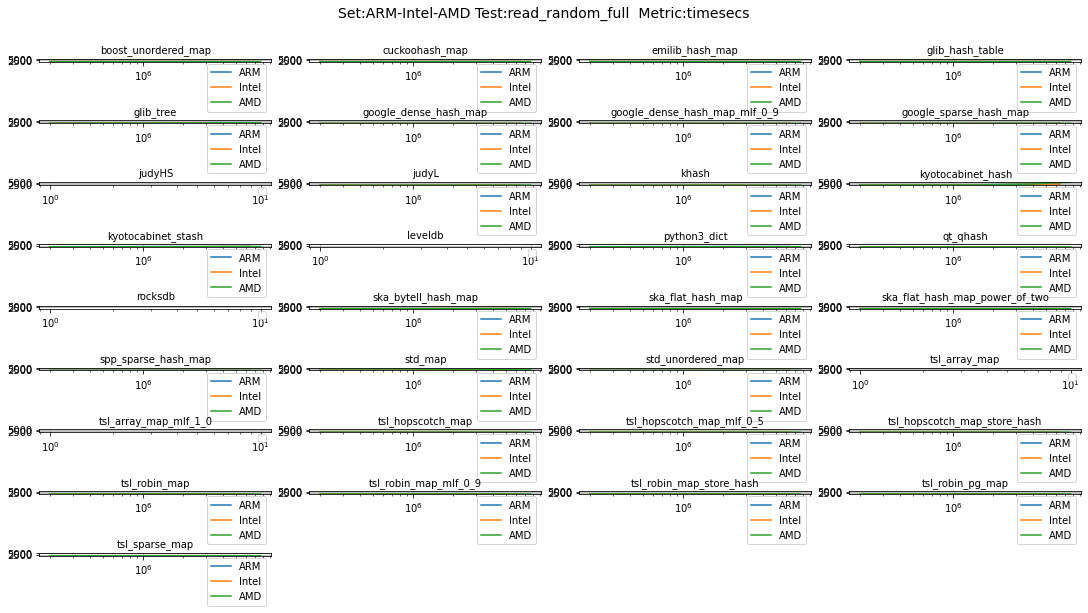

No handles with labels found to put in legend.


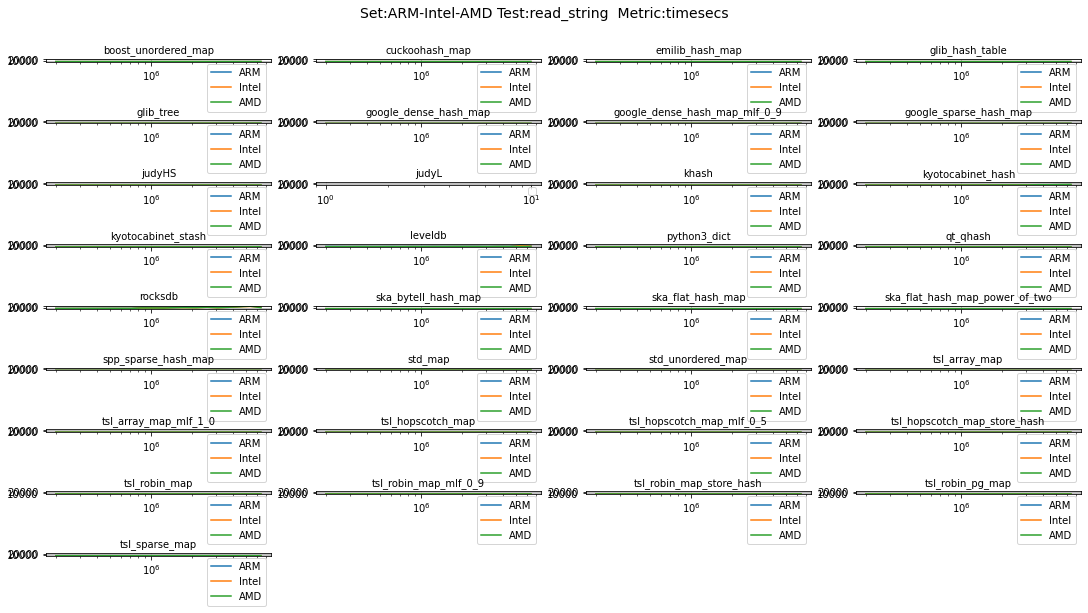

In [68]:
tests = {'ARM':armfull, 'Intel':intelfull, 'AMD': amdfull }
plot_containers( tests, ('timesecs',), None, ('read_random_full',), columns=4 )
plot_containers( tests, ('timesecs',), None, ('read_string',), columns=4 )

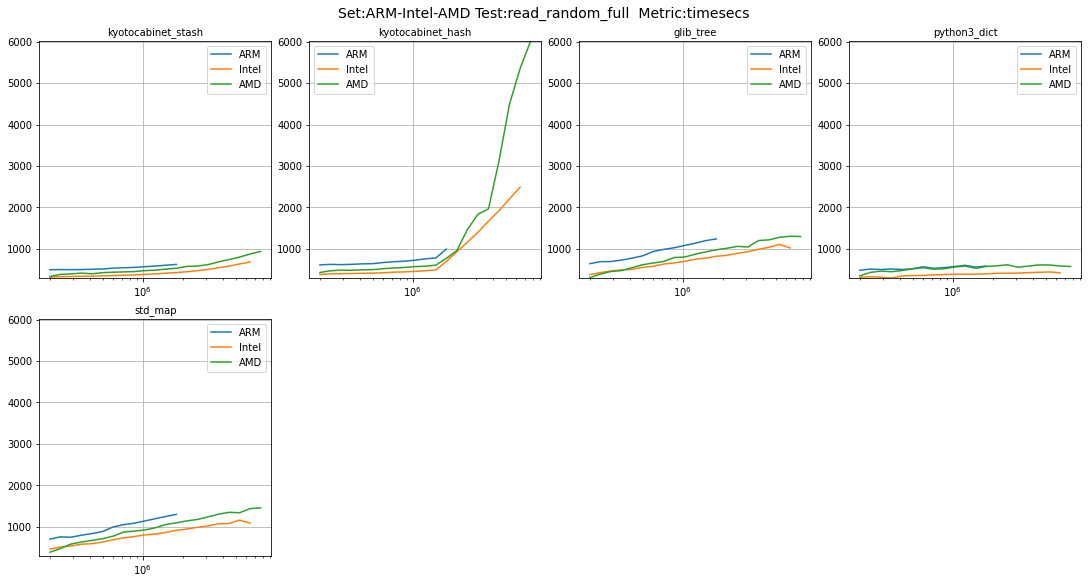

{'tsl_array_map', 'ska_flat_hash_map_power_of_two', 'tsl_array_map_mlf_1_0', 'judyL', 'google_sparse_hash_map', 'tsl_robin_map_store_hash', 'google_dense_hash_map_mlf_0_9', 'qt_qhash', 'spp_sparse_hash_map', 'emilib_hash_map', 'tsl_hopscotch_map', 'glib_hash_table', 'ska_flat_hash_map', 'khash', 'boost_unordered_map', 'tsl_robin_map', 'cuckoohash_map', 'tsl_hopscotch_map_store_hash', 'tsl_sparse_map', 'tsl_robin_pg_map', 'tsl_robin_map_mlf_0_9', 'google_dense_hash_map', 'ska_bytell_hash_map', 'std_unordered_map', 'tsl_hopscotch_map_mlf_0_5', 'judyHS'}


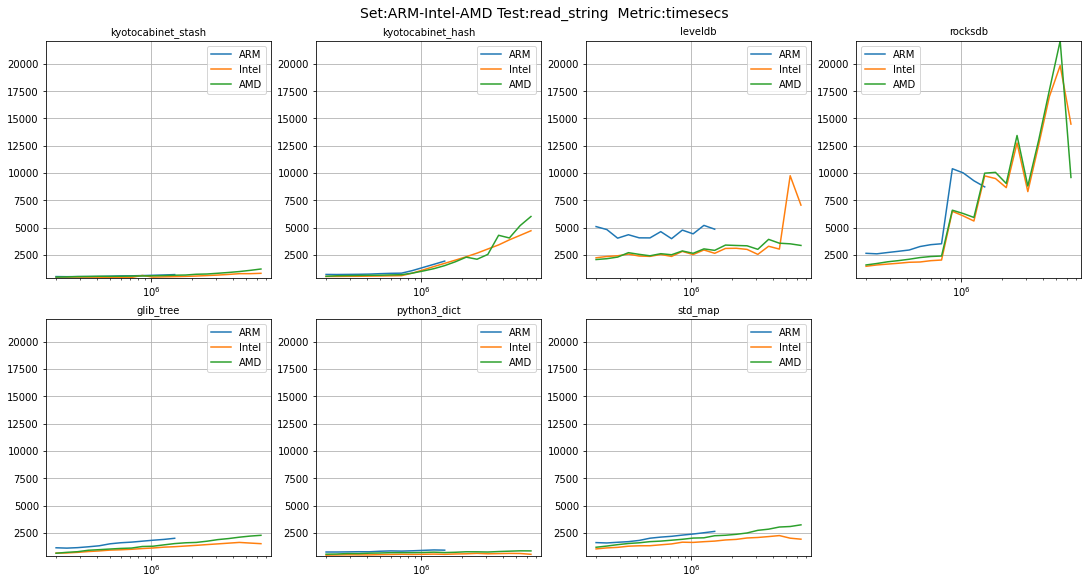

In [65]:
plot_containers( tests, ('timesecs',), slow_containers, ('read_random_full',), columns=4 )

slow_string_containers = set( ('leveldb', 'rocksdb',) ) 
print( all_containers - slow_string_containers )
plot_containers( tests, ('timesecs',), slow_string_containers, ('read_string',), columns=4 )

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


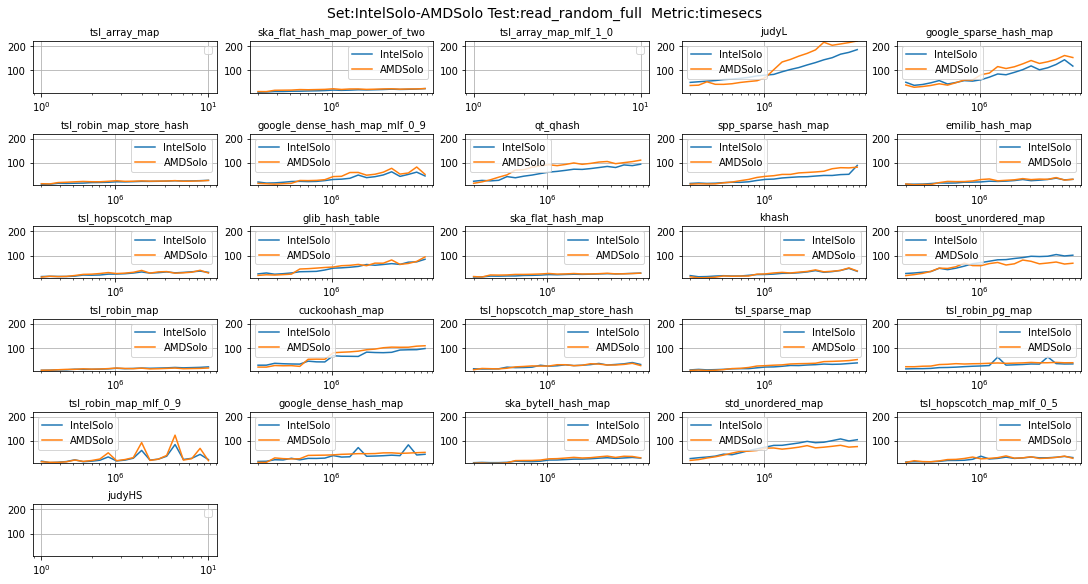

In [47]:
fast_containers = ('std_unordered_map', 'boost_unordered_map', 'google_dense_hash_map', 
                   'google_sparse_hash_map','qt_qhash','ska_bytell_hash_map','ska_flat_hash_map_power_of_two',
                  'spp_sparse_hash_map', 'tsl_hopscotch_map', 'tsl_hopscotch_map_store_hash', 
                  'tsl_robin_map', 'tsl_sparse_map')
fast_string_containers = 
fast_containers = all_containers - slow_string_containers
plot_containers( tests, ('timesecs',), fast_containers, ('read_random_full',), columns=5 )


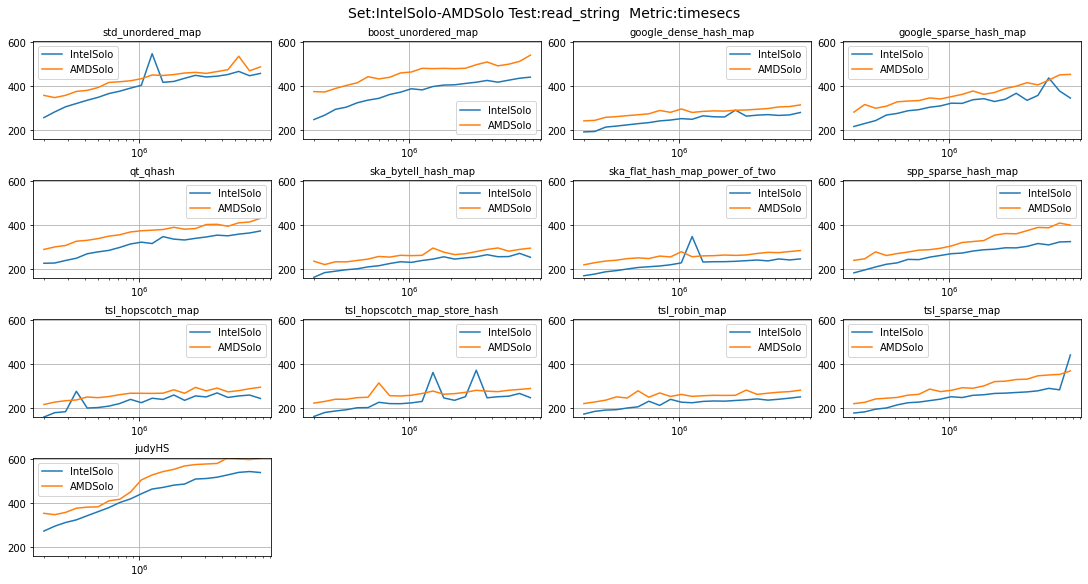

In [23]:
fast_string_containers = fast_containers + ('judyHS',)
plot_containers( tests, ('timesecs',), fast_string_containers, ('read_string',), columns=4 )

No handles with labels found to put in legend.
No handles with labels found to put in legend.


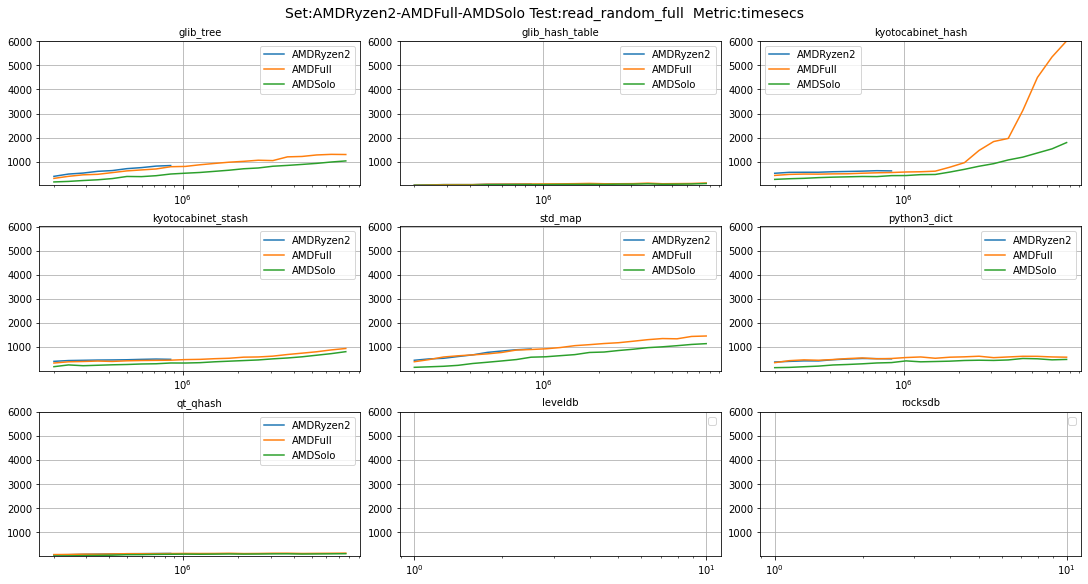

In [6]:

plot_containers( tests, ('timesecs',), slow_containers, ('read_random_full',) )

## Effects of optimization flags
We ran these tests by compiling two sets of binaries, one with "-O1" and another with "-O3". The datasets are then loaded and plotted side by side. 
The first graph shows that timing is not affected for most operations as the results stand on top of each other. One important exception is for lookups (read operations) where performance is significantly affected. The effects are the same for integers, small strings and string equally. 

In [7]:
amdsoloO1 = load_data_file( 'output-amdsolo-optimo1' )
amdsoloO3 = load_data_file( 'output-amdsolo-perfcounter' )
testmap = {'Optim -O3':amdsoloO3,'Optim -O1':amdsoloO1}
plot_tests_multi( testmap, ('timesecs',), ('std_unordered_map',), None)

NameError: name 'plot_tests_multi' is not defined

The effects on std::map are much less though. There is very little difference between the test runs. 

In [ ]:
plot_tests_multi( testmap, ('timesecs',), ('std_map',), None)

The effect of optimization on cache misses is more pronounced though with an overall 10-20% increase in cache misses due to the extra optimization across the board. 
There is no noticeable effect on any other metric 


In [ ]:
plot_tests_multi( testmap, None, ('std_unordered_map',), None)

# Loading 

In [ ]:
intelfull = load_data_file( 'output-intelfull-perfcounter')
intelfullx86 = load_data_file( 'output-intelfull-perfx86' )
amdfull = load_data_file( 'output-amdfull-perfcounter' )
amdsolo = load_data_file( 'output-amdsolo-perfcounter' )
intelsolo = load_data_file( 'output-intelsolo-perfcounter')
amdsolox86 = load_data_file( 'output-amdsolo-perfx86' )
#intelfullname = 'output-xeon8252c-full'
#intelfull = load_data_file( intelfullname )
#intelsoloname = 'output-xeon8252c-solo'
#intelsolo = load_data_file( intelsoloname )

In [ ]:
print( set( [ t for t,ct in amdsolo.keys() ] ) )

In [ ]:
#mymetrics = ('timesecs','nanosperinst','nanospercycle','instructions','cycles','cachemisses','pagefaults','branches','memsize','pagefaults-min')
mymetrics = ('timesecs','cachemisses','pagefaults-min')
#myct = ('google_dense_hash_map','std_unordered_map','qt_qhash','ska_bytell_hash_map','judyL','tsl_robin_map','boost_unordered_map')
mytests = ('insert_string',)
#mymetrics = ('timesecs','branchmisses','cachemisses','')
#myct = ('google_dense_hash_map','ska_bytell_hash_map','judyL','std_unordered_map','qt_qhash','tsl_robin_map')
myct = ('leveldb','rocksdb','std_map','kyotocabinet_stash','kyotocabinet_hash','glib_tree')
#testmap = {'AMDFull':amdfull,'AMDSolo':amdsolo,'IntelSolo':intelsolo,'IntelFull':intelfull,'AMDSoloX86':amdsolox86, 'IntelFullX86':intelfullx86}
testmap = {'AMDSolo':amdsolo} #,'AMDSoloX86':amdsolox86,'IntelFull':intelfull,'IntelFullX86':intelfullx86}
#plot_metrics_multi( testmap, mymetrics, myct, mytests)
results = {'AMDFull':amdfull,'AMDSolo':amdsolo,'AMDSoloX86':amdsolox86,'IntelSolo':intelsolo,'IntelFull':intelfull,'IntelFullX86':intelfullx86}
plot_containers_multi( results, mymetrics, myct,mytests)


#plot_containers( intelsoloname, intelsolo, mymetrics, myct, mytests )
#plot_containers( amdfullname, amdfull, mymetrics, myct, mytests )
#plot_containers( intelfullname, intelfull, mymetrics, myct, mytests )

In [ ]:
mymetrics = ('timesecs','cachemisses')
myct = ('std_unordered_map','ska_bytell_hash_map','judyL','tsl_robin_map')
mytests = ('insert_random_full','read_random_full',)
plot_tests( amdsoloname, amdsolo, mymetrics, myct, mytests )
#plot_tests( intelsoloname, intelsolo, mymetrics, myct, mytests )
#plot_tests( amdfullname, amdfull, mymetrics, myct, mytests )
#plot_tests( intelfullname, intelfull, mymetrics, myct, mytests )


In [ ]:
tests = ('cachemisses','branchmisses')
plot_containers( amdfullname, amdfull, ('instructions',), myct, tests )
plot_containers( intelfullname, intelfull, ('instructions',), myct, tests )